<Axes: >

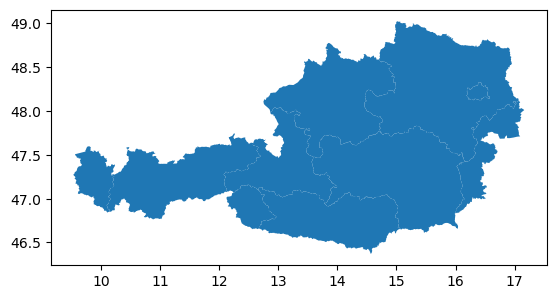

In [199]:
import geopandas as gpd

source = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-AUT.gpkg" 

regions = gpd.read_file(source) #reading in the source 
regions = regions.set_index("GID_1")

regions.plot()

In [200]:
regions.head(10) #checking how the data looks like 

,GID_0,COUNTRY,NAME_1,geometry
GID_1,,,,
AUT.1_1,AUT,Austria,Burgenland,"MULTIPOLYGON (((16.06708 46.84898, 16.06715 46..."
AUT.2_1,AUT,Austria,Kärnten,"MULTIPOLYGON (((14.43536 46.44339, 14.43537 46..."
AUT.3_1,AUT,Austria,Niederösterreich,"MULTIPOLYGON (((16.25377 47.44783, 16.25377 47..."
AUT.4_1,AUT,Austria,Oberösterreich,"MULTIPOLYGON (((13.70853 47.5804, 13.71036 47...."
AUT.5_1,AUT,Austria,Salzburg,"MULTIPOLYGON (((13.69971 47.00418, 13.69947 47..."
AUT.6_1,AUT,Austria,Steiermark,"MULTIPOLYGON (((15.52438 46.62453, 15.52435 46..."
AUT.7_1,AUT,Austria,Tirol,"MULTIPOLYGON (((10.62411 46.86447, 10.62405 46..."
AUT.8_1,AUT,Austria,Vorarlberg,"MULTIPOLYGON (((10.12938 47.02719, 10.12959 47..."
AUT.9_1,AUT,Austria,Wien,"MULTIPOLYGON (((16.29905 48.12999, 16.29897 48..."


In [201]:
#adding attributes to the dataframe for aggregating the geometries to 5 regions therefore mapping the new Region names to the NAME_1 entries
new_regions = {
    "Wien": "Wien",
    "Niederösterreich": "Niederösterreich/Burgenland",
    "Burgenland": "Niederösterreich/Burgenland",
    "Oberösterreich": "Oberösterreich/Salzburg",
    "Salzburg": "Oberösterreich/Salzburg",
    "Tirol": "Tirol/Vorarlberg",
    "Vorarlberg": "Tirol/Vorarlberg",
    "Kärnten": "Kärnten/Steiermark",
    "Steiermark": "Kärnten/Steiermark"
}

regions["region_5"] = regions["NAME_1"].map(new_regions)

#now dissolving the geometries on "region_5" regions
regions_5 = regions.dissolve(by="region_5")


<Axes: >

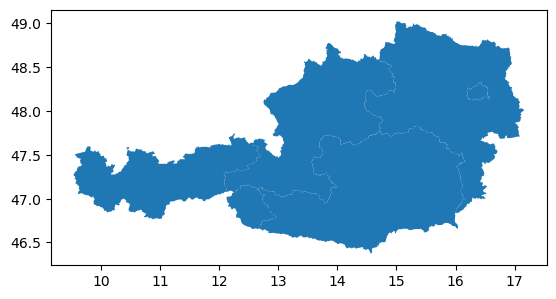

In [202]:
#checking the new region
regions_5.plot()

,geometry,GID_0,COUNTRY,REP_POINT
region_5,,,,
Kärnten/Steiermark,"POLYGON ((14.43537 46.44343, 14.43537 46.44345...",AUT,Austria,POINT (14.98609 47.10053)
Niederösterreich/Burgenland,"POLYGON ((16.06715 46.84889, 16.0672 46.84884,...",AUT,Austria,POINT (15.92138 47.92607)
Oberösterreich/Salzburg,"POLYGON ((13.69947 47.00479, 13.69858 47.00534...",AUT,Austria,POINT (13.86111 47.85873)
Tirol/Vorarlberg,"MULTIPOLYGON (((12.39612 46.71143, 12.39598 46...",AUT,Austria,POINT (10.82959 47.25349)
Wien,"POLYGON ((16.29905 48.12999, 16.29897 48.12999...",AUT,Austria,POINT (16.37248 48.2208)


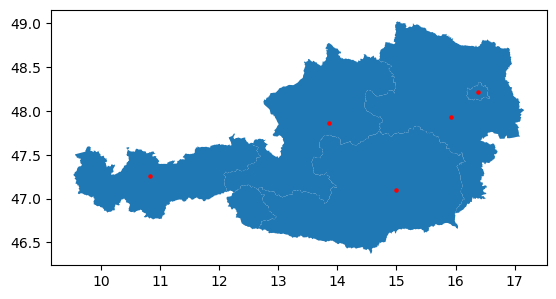

In [203]:
#adding representative points
regions_5["REP_POINT"] = regions_5.representative_point()

#checking the points
ax = regions_5.plot()
regions_5["REP_POINT"].plot(ax=ax, color="red", markersize =5)

#for later use searching looking on the final dataframe and removing NAME_1 because it is no longer needed
regions_5 = regions_5.drop("NAME_1", axis="columns")
regions_5

In [ ]:
#Part 2 Renewable Potentials 
#First: Land eligibility analysis wind on shore
#Source buffers: https://boku.ac.at/fileadmin/data/H03000/H73000/H73200/TransWind/Flaechenpotentiale_Windkraftnutzung.pdf
#Source Land cover classes for Austria: https://www.parcs.at/nphtt/pdf_public/2014/30611_20141209_154737_CORINE_Nomenklatur.pdf
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
import matplotlib.pyplot as plt
from rasterio.plot import show

excluder = ExclusionContainer(crs=3035, res=100)

#adding all sources
shape_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
protected_areas_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-AUT.tif"
copernicus_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-AT.tif"
elevation_url = "GEBCO_2014_2D-AT.nc"
airports_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg"
roads_url = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg"

In [ ]:
countries = gpd.read_file(shape_url).set_index("name")
shape = countries.to_crs(excluder.crs).loc[["AT"]].geometry
shape = shape.to_crs(epsg=3035).geometry

In [206]:
#adding exclusion criteria for roads and airports as well as protection areas
excluder.add_geometry(roads_url, buffer= 300) #buffer 300 m
excluder.add_geometry(airports_url, buffer = 5100) #buffer 5100m (different because we found a source from transwind that suggested 5100 m)
excluder.add_raster(protected_areas_url, crs=3035)


In [ ]:

# exclusion codes for build up areas (cities or buildings near cities)
codes_urban = [50] #buffer 1000

#exclusion codes for water bodies and Wetlands and glaciers
codes_water_bodies_glaciers = [70, 80, 90] #1000 m buffer
#exclusion codes for woods becasue the suggestion of the document sais 
#they would exclude woods except of commercial forrest which can not be identified through the copernicus dataset
codes_woods = [111, 114, 115, 116, 121, 124, 125, 126]
#codes to include (can stil be excluded through natural protection areas), bare rocks can be hard to reach and will be excluded through the slope criterion
codes_to_include = [20, 30, 40, 60, 100 ]

In [ ]:
#adding exclusion from the CORINE dataset
#urban with 1000 m buffer (from suggestion paper)
excluder.add_raster(copernicus_url, codes=codes_urban, crs=3035, buffer=1000, nodata=255)

#for water bodies and Wetlands and glaciers with 1000m buffer 
excluder.add_raster(copernicus_url, codes=codes_water_bodies_glaciers, buffer= 1000, crs=3035, nodata=255)

#for woods 
excluder.add_raster(copernicus_url, codes=codes_woods,  crs=3035, nodata=255)
#adding inclusion codes
excluder.add_raster(copernicus_url, codes=codes_to_include, crs=3035, invert=True, nodata=255)

In [ ]:
#getting the rasters for hights above 2000m
def exclude_above_2000m(raster):
    return raster > 2000
#exclude rasters over 2000m 
excluder.add_raster(elevation_url,crs=4326,codes=exclude_above_2000m)


c:\Users\Tobias\anaconda3\anaconda\envs\DSESM\Lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:


<Axes: >

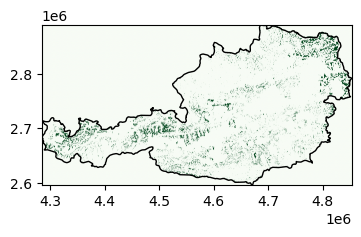

In [210]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

In [ ]:
#for solar
excluder_solar = ExclusionContainer(crs=3035, res=100)
excluder_solar.add_raster(protected_areas_url, crs=3035)

